## 1. Data Pre-processing

### 1.1 Load Data

In [44]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install rich

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

intersection = ['rlc',
 'loom',
 'mx',
 'cream',
 'zrx',
 'rep',
 'nmr',
 'okb',
 'band',
 'aave',
 'bix',
 'matic',
 'ubt',
 'abt',
 'gno',
 'usdt',
 'elf',
 'perp',
 'ftt',
 'busd',
 'drgn',
 'mco',
 'armor',
 'rsr',
 'mtl',
 'nexo',
 'eng',
 'wnxm',
 'cnd',
 'wabi',
 'cvc',
 'ldo',
 'mta',
 'crv',
 'qash',
 'bzrx',
 'stake',
 'hpt',
 'bal',
 'wbtc',
 'mkr',
 'mcb',
 'san',
 'eurs',
 'uni',
 'cvp',
 'ocean',
 'yfi',
 'ppt',
 'cro',
 'pickle',
 'rook',
 'tel',
 'mana',
 'poly',
 'wax',
 'btc',
 'pnk',
 'snx',
 'susd',
 'bnt',
 'dough',
 'badger',
 'link',
 'dodo',
 'ampl',
 'qnt',
 'nsure',
 'uma',
 'veri',
 'top',
 'chsb',
 'mln',
 'dgx',
 'dent',
 'mir',
 'kcs',
 'snt',
 'ddx',
 'hegic',
 'qkc',
 'eth',
 'sai',
 'utk',
 'lba',
 'sushi',
 'dai',
 'yam',
 'comp',
 'enj',
 'index',
 'fun',
 'mft',
 'pnt',
 'usdk',
 'omg',
 'ant',
 'nftx',
 'ht',
 'lamb',
 'bond',
 'gusd',
 'rpl',
 'usdp',
 'ndx',
 'ren',
 'leo',
 'lrc',
 'pay',
 'dmg',
 'ltc',
 'brd',
 'celr',
 'bat',
 'hot',
 'powr',
 'wtc',
 'usdc',
 'husd',
 'dht',
 'rdn',
 'storj',
 'fet']

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC', 'AAVE', 'MLN', 'YAM']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### 1.2 Get Multiple Attributes for Multiple Coins:

In [47]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [48]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from fredapi import Fred
    from rich.console import Console
    console = Console()

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Show Welcome
    console.print(
        "Loading [bold magenta]All Coins[/bold magenta] Data. This Might Take A While")

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Init Loop Count
    count = 1

    # Data Pull
    for i in coinList:
        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Progress Bar Init
        from rich.progress import (Progress,
                                   TextColumn,
                                   BarColumn,
                                   TaskProgressColumn,
                                   TimeRemainingColumn)

        progress = Progress(TextColumn("[progress.description]{task.description}"),
                            BarColumn(),
                            TaskProgressColumn(),
                            TimeRemainingColumn(compact=True,
                                                elapsed_when_finished=True,),
                            expand=True,
                            transient=True)

        with progress:
            # Get data
            for j in progress.track(endPoints.keys(),
                                    description=f"Pulling {i}'s Data, Coins Ramaining: {len(coinList) - count}"):
                locals()[frameName].append(PullData(i,
                                                    j))

        # Loop Count + 1
        count += 1

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             on='Date',
                                                             how='left').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                              ignore_index=True)

    console.print('All Frames Merged')
    console.print('\nALL DATA [bold green]SUCCESSFULLY[/bold green] PULLED!')

    return fullFrame

### 1.3 Removing Stable Cryptocurrencies and Cryptocurrencies which stopped trading .

If the price for the asset is missing for the latest 4 weeks , then we consider it as a cryto currency that stopped trading, we won't include it in our sample. (this should be done before return calculation)

In [49]:
def StoppedTrading(sample: pd.DataFrame):
    """This Method will remove crypto currencies stopped trading.

    Args:
        sample (pd.DataFrame): The Pulled Data 

    Returns:
        fullFrame (pd.DataFrame): A DataFrame with all cryptocurrencies stopped trading removed.
    """
    # Initialization
    validFrame = pd.DataFrame(columns=list(sample.columns))

    orgcols = list(sample.columns)
    orgcols.remove('RiskFree')
    
    

    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
         
        if (segment['Price'][-4:].isnull().sum() < 4):
            temp = pd.DataFrame()
            temp[orgcols] = segment[orgcols]
            temp['RiskFree'] = segment[['RiskFree']].interpolate(
                method='linear', limit_direction='forward', axis=0)
            validFrame = pd.concat([validFrame, temp], ignore_index=True)

    return validFrame

### 1.4 Calculate Returns

In [50]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns))
    
    ### replace 0 values in active address to 1
    new = sample.copy()
    new.drop(['ActiveAddress'], axis = 1)
    new['ActiveAddress'] = sample['ActiveAddress'].replace({0.0:1.0})
    
    ###
    
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = new.query(syntax)
        segment = segment.assign(Return = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]).copy())
        segment = segment.assign(week2_return = segment.Price.rolling(4).apply(lambda x: (x.iloc[-2]-x.iloc[0])/x.iloc[0]))
        segment = segment.assign(Npast52_return = segment.Price.rolling(53).apply(lambda x: (x.iloc[-2]-x.iloc[0])/x.iloc[0]))
        segment = segment.assign(GrowthRate = segment.ActiveAddress.rolling(3).apply(lambda x: np.log(x.iloc[-2])-np.log(x.iloc[0])
                                                                                     if ((x.iloc[0]>0 and x.iloc[-2]>0)) else np.nan ))                                                                                                                                                                                                                                                                                                    
        segment = segment.assign(lagCap = segment.MarketCap.shift())
                                 
        #############remove stable currency ########### 
        stdvar = segment.Return.std()
    
        ##################                         
        if stdvar > 0.005:
            segment = segment[-52:].reset_index(drop=True)
            fullFrame = pd.concat([fullFrame, segment],
                                         ignore_index=True)
            fullFrame["ExcessReturn"] = fullFrame["Return"] - fullFrame["RiskFree"]

    return fullFrame

### 1.5 Initialize 

In [51]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

Loading All Coins Data. This Might Take A While

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!

In [52]:
# remove crypto currencies stopped trading.
validfullSample_raw = StoppedTrading(fullSample_raw)


In [53]:
# Add Return to fullSample and remove stable currency
fullSample = AddReturn(validfullSample_raw)

### 1.6 Get the large capitalization portfolio - largeCapSample 
Use (maket cap > 1m and top 100) to set up the dynamic porfolio for each week, we would use this dynamic portfolio for our factors calculation.

In [54]:
largeCapport = fullSample.query("lagCap > 1000000")
largeCapSample = largeCapport.groupby(['Date']).apply(lambda x: x.nlargest(100,['lagCap'])).reset_index(drop=True)

### <font color ='red'> TEST SECTION, keep for reference

In [55]:
before = fullSample_raw.Asset.unique().tolist()
len(before)

124

In [56]:
after = fullSample.Asset.unique().tolist()
len(after)

117

In [57]:
list(set(before)-set(after))  #remove below cryptocurrencies which either stop trading or stable

['WAX', 'USDT', 'USDC', 'BUSD', 'HUSD', 'SAI', 'MCO']

In [58]:
a = validfullSample_raw.query("Asset == 'UST' ")

In [59]:
a = a.assign(Return = a.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]).copy())
sv = a.Return.std()

In [60]:
me = a.Return.mean()

### 1.7 Generate csv file for the loaded raw data

In [61]:
latestdate = fullSample_raw.Date.max()
filename1 = "fullSample_rawdata"+latestdate.strftime("%Y%m%d")+".csv"

fullSample_raw.to_csv(filename1)

In [62]:
largeCapSample.isna().sum()

Date                0
Price               0
MarketCap           0
ActiveAddress       0
RiskFree            0
Asset               0
Return              0
week2_return        0
Npast52_return    461
GrowthRate          0
lagCap              0
ExcessReturn        0
dtype: int64

## 2. MKT Factor (Fiona)

### 2.1 Calculate MKT for each week

We chose the crypto currencies which have market cap greatter than 1m and ranked in the top 100 as our market portfolio and using value weighted method to calcuate the market index return.

In [63]:
mktport = largeCapSample[largeCapSample['Return'].notna()]
marketport = mktport.groupby('Date')['lagCap'].sum().reset_index(name='TotalMarketCap')

marketInd = mktport.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['lagCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [64]:
riskfree = mktport.groupby('Date')['RiskFree'].mean().reset_index()
marketport = marketport.merge(riskfree, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

In [65]:
MKT_f.head()

,Date,MKT
0,2021-05-17,-0.316514
1,2021-05-24,0.067108
2,2021-05-31,0.041553
3,2021-06-07,0.025007
4,2021-06-14,-0.087891


### 2.2 MKT_f - market factor

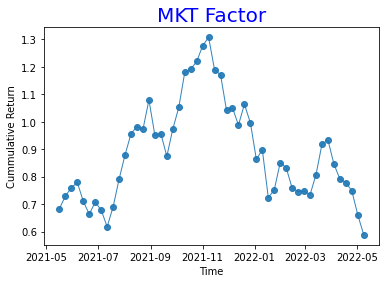

In [66]:
import matplotlib.pyplot as plt

plt.plot(MKT_f.Date, np.cumprod(1+MKT_f.MKT), marker='o', linewidth=1, alpha=0.9, label=MKT_f.MKT)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 3. SMB Factor (Fiona)

### 3.1 Using quintile method to get the portfolios for top 20%, and bottom 20% based on the cap for each week

Using equal weighted method to calucated the returns for the small protfolios and large portfolios. The difference is the SMB factor.

In [67]:
largeCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(math.ceil(0.2*len(x)),
                                                              ['lagCap'])).reset_index(drop=True)

smallCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(math.ceil(0.2*len(x)),
                                                              ['lagCap'])).reset_index(drop=True)
largeCap.head()

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,GrowthRate,lagCap,ExcessReturn
0,2021-05-17,34888.678313,6.530094e+11,4960283.0,0.0,BTC,-0.248191,-0.180291,4.277670,-0.088389,8.683518e+11,-0.248191
1,2021-05-17,2116.929035,2.455595e+11,2985344.0,0.0,ETH,-0.409063,0.213316,16.681685,-0.018539,4.152052e+11,-0.409063
2,2021-05-17,144.373194,9.776754e+09,1305682.0,0.0,LTC,-0.513065,0.101960,5.978366,0.061791,2.006374e+10,-0.513065
3,2021-05-17,16.902525,9.513939e+09,22581.0,0.0,UNI,-0.536542,-0.139635,NaN,-0.408560,1.987142e+10,-0.536542
4,2021-05-17,20.134911,8.597920e+09,57476.0,0.0,LINK,-0.505011,0.030852,9.593280,-0.227682,1.722544e+10,-0.505011


### 3.2 Using equal-weighted average method to get the SMB
SMB = equal-weighted average of returns on small portfolis - equal-weighted average of returns on large portfolis

In [68]:
largeport = largeCap.groupby('Date')['Return'].mean().reset_index(name='LargePortReturn')
smallport = smallCap.groupby('Date')['Return'].mean().reset_index(name='SmallPortReturn')
smallport['SMB'] = smallport['SmallPortReturn'] - largeport['LargePortReturn']
SMB_f = smallport[['Date','SMB']]

In [69]:
SMB_f.head()

,Date,SMB
0,2021-05-17,-0.045142
1,2021-05-24,-0.008970
2,2021-05-31,0.036589
3,2021-06-07,0.000084
4,2021-06-14,0.014350


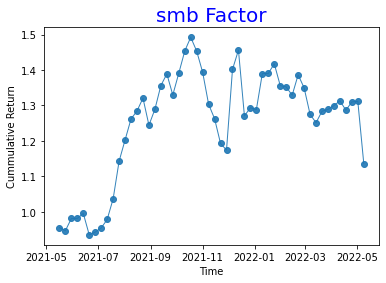

In [70]:
plt.plot(SMB_f.Date, np.cumprod(1+SMB_f.SMB), marker='o',
         linewidth=1, alpha=0.9, label=SMB_f.SMB)
plt.title("smb Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

In [71]:
# ### do not run!! just keep previous result plots for 

# plt.plot(SMB_f.Date, np.cumprod(1+SMB_f.SMB), marker='o',
#          linewidth=1, alpha=0.9, label=SMB_f.SMB)
# plt.title("smb Factor", loc='center', fontsize=20, fontweight=0, color='blue')
# plt.xlabel("Time")
# plt.ylabel("Cummulative Return")
# plt.show()

## 4. VAL Factor (Lydia)

**Reshape to get two tables with: Npast52_return, Return(weekly)**

In [72]:
npast52 = largeCapSample.pivot(index="Date",
                               columns=["Asset"],
                               values='Npast52_return').reset_index().rename_axis(None,
                                                                                  axis=1).sort_values('Date')


value_return = largeCapSample.pivot(index='Date',
                                    columns=['Asset'],
                                    values='Return').reset_index().rename_axis(None,
                                                                               axis=1).sort_values('Date')


In [73]:
cols=list(largeCapSample.Asset.unique())

npast52['top20'] = npast52[cols].quantile(q=0.8,axis=1, numeric_only=True, interpolation='linear') 
npast52['low20'] = npast52[cols].quantile(q=0.2,axis=1, numeric_only=True, interpolation='linear') 

**check whether Npast52 of a coin in a day is in low20 or top20, then calculate the weekly return mean of low20 and top20 , respectively**

In [74]:
VAL_low = value_return[npast52[cols].apply(lambda x: x <= npast52['low20'])].mean(axis=1, numeric_only=True)
VAL_top = value_return[npast52[cols].apply(lambda x: x >= npast52['top20'])].mean(axis=1, numeric_only=True)

**calculate Value factor using long-short method**

In [75]:
valueFactor = pd.DataFrame(columns = ['Date','VAL'])
valueFactor['Date'] = value_return['Date']
valueFactor['VAL'] = VAL_top - VAL_low

In [76]:
valueFactor.head()

,Date,VAL
0,2021-05-17,-0.200273
1,2021-05-24,0.100486
2,2021-05-31,0.081835
3,2021-06-07,-0.101157
4,2021-06-14,-0.005874


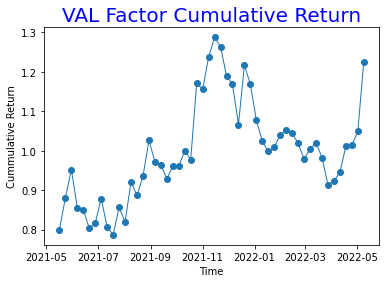

In [78]:
from matplotlib.pyplot import figure

plt.plot(valueFactor.Date, np.cumprod(1+valueFactor.VAL), marker='o', linewidth=1)
plt.title("VAL Factor Cumulative Return", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

In [79]:
# previous plot result
# from matplotlib.pyplot import figure

# plt.plot(valueFactor.Date, np.cumprod(1+valueFactor.VAL), marker='o', linewidth=1)
# plt.title("VAL Factor Cumulative Return", loc='center', fontsize=20, fontweight=0, color='blue')
# plt.xlabel("Time")
# plt.ylabel("Cummulative Return")
# plt.show()

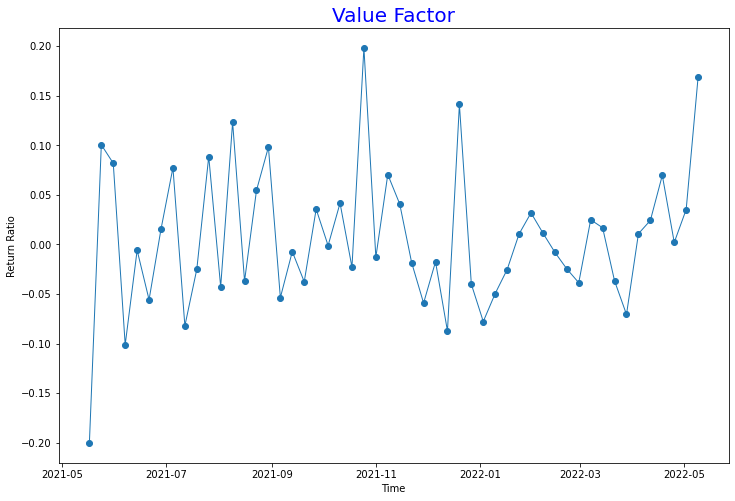

In [80]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
 
plt.plot(valueFactor.Date, valueFactor.VAL, marker='o', linewidth=1)

plt.title("Value Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

## 5. MOM Factor (Sean)

In [81]:
def getMomFactor(largeCapSample: pd.DataFrame):
    """This Method Returns Momentum Factor

    Args:
        largeCapSample (pd.DataFrame): Large Cap Sample

    Returns:
        momFactor (pd.DataFrame): Contains Momentum Factor
    """
    # Pivot largeCapSample to Get Return Matrix
    returnAll = largeCapSample.pivot(index="Date",
                                     columns=["Asset"],
                                     values='Return').reset_index().rename_axis(None,
                                                                                axis=1).sort_values('Date')

    # Pivot largeCapSample to Get Momentum Matrix(Past 2-Week Returns)
    momMatrix = largeCapSample.pivot(index="Date",
                                     columns=["Asset"],
                                     values='week2_return').reset_index().rename_axis(None,
                                                                                      axis=1).sort_values('Date')

    # Calculate the Momentum Percentile
    col = sorted(largeCapSample.Asset.unique())

    momPt = pd.DataFrame(columns=['MOM20p',
                                  'MOM80p'])

    momPt['MOM20p'] = momMatrix[col].quantile(.2, axis=1)
    momPt['MOM80p'] = momMatrix[col].quantile(.8, axis=1)

    # Calculate MOM Factor
    MOM = pd.DataFrame({'Date': []})
    MOM['Date'] = returnAll.Date
    MOM['HighMomentum'] = returnAll.drop("Date", axis=1)[momMatrix[sorted(largeCapSample.Asset.unique())].apply(
        lambda x: x >= momPt['MOM80p'])].mean(axis=1, numeric_only=True)
    MOM['LowMomentum'] = returnAll.drop("Date", axis=1)[momMatrix[sorted(largeCapSample.Asset.unique())].apply(
        lambda x: x <= momPt['MOM20p'])].mean(axis=1, numeric_only=True)
    MOM['MOM'] = MOM.HighMomentum - MOM.LowMomentum
    momFactor = MOM.drop(columns=['HighMomentum', 'LowMomentum'])
    return momFactor


In [82]:
momFactor = getMomFactor(largeCapSample)

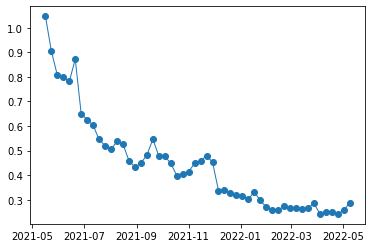

In [83]:
from matplotlib.pyplot import figure

plt.plot(momFactor.Date, np.cumprod(1+momFactor.MOM), marker='o', linewidth=1)

In [84]:
# from matplotlib.pyplot import figure

# plt.plot(momFactor.Date, np.cumprod(1+momFactor.MOM), marker='o', linewidth=1)

## 6. NET Factor (Zachary)

### Get Address Growth

In [85]:
Growth = largeCapSample.pivot(index='Date',
                              columns='Asset',
                              values='GrowthRate').reset_index().rename_axis(None,
                                                                             axis=1)
cols = largeCapSample.Asset.unique().tolist()

Growth['20Percentile'] = Growth[cols].quantile(q=0.2,
                                               numeric_only=True,
                                               axis=1)
Growth['80Percentile'] = Growth[cols].quantile(q=0.8,
                                               numeric_only=True,
                                               axis=1)


### Construct Network factor

In [86]:
Return = largeCapSample.pivot(index='Date',
                              columns='Asset',
                              values='Return').reset_index().rename_axis(None,
                                                                         axis=1)

NET = pd.DataFrame({'Date': []})
NET['Date'] = Return.Date

# Lambda function disordered the columns, added additional step to sort columns in alphabetical order
long = Growth[cols].apply(lambda x: x >= Growth['80Percentile'])
long = long.reindex(sorted(long.columns), 
                    axis=1)
NET['long'] = Return[long].mean(axis=1,
                                numeric_only=True)

short = Growth[cols].apply(lambda x: x <= Growth['20Percentile'])
short = short.reindex(sorted(short.columns), 
                      axis=1)
NET['short'] = Return[short].mean(axis=1, 
                                  numeric_only=True)

NET['NET'] = NET['long'] - NET['short']
NET.drop(columns=['short', 'long'])
NET = NET[['Date', 'NET']]
NET.head()


,Date,NET
0,2021-05-17,0.057495
1,2021-05-24,0.026623
2,2021-05-31,0.007274
3,2021-06-07,0.031813
4,2021-06-14,-0.006582


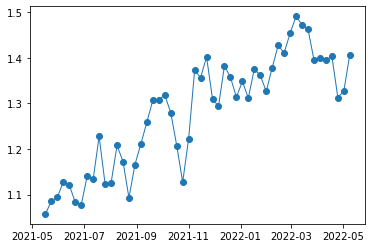

In [87]:
from matplotlib.pyplot import figure

plt.plot(NET.Date, np.cumprod(1+NET.NET), marker='o', linewidth=1)

In [88]:
# from matplotlib.pyplot import figure

# plt.plot(NET.Date, np.cumprod(1+NET.NET), marker='o', linewidth=1)

## 7.Regression Output
### 7.1 Output a list of alphas for all the crypto currencies using factors
Note: Only pick the top 100 cypto currencies from the latest week and check their alphas.

In [89]:
factorList = [MKT_f, SMB_f, valueFactor, momFactor, NET]


def ModelBuild(fullSample,
               factorList):
    from sklearn.linear_model import LinearRegression

    largeCapSample = fullSample.query("lagCap > 1000000").groupby(['Date']).apply(
        lambda x: x.nlargest(100, ['lagCap'])).reset_index(drop=True)

    performance = {}

    ## find the top 100 cypto currencies at the last week

    latest = largeCapSample.Date.max()
    latestLarge = largeCapSample.query("Date == @latest")

    # factors = factors.merge(MOM_f, on = 'Date', how ='outer')
    from functools import reduce
    factors = reduce(lambda left, right:
                     pd.merge(left,
                              right,
                              on='Date',
                              how='outer'),
                     factorList)

    features = factors.columns.tolist()
    features.remove('Date')
    target = "ExcessReturn"

    ###output the csv file for our regression data
    assetList = latestLarge['Asset'].tolist()
    regressionFrame = fullSample.loc[fullSample['Asset'].isin(assetList)]
    regressionData = regressionFrame.merge(factors, on='Date', how='outer')

    filename = "regressionData"+latest.strftime("%Y%m%d")+".csv"
    regressionData.to_csv(filename)

    for index in assetList:
        syntax = f"Asset == '{index}'"
        segment = fullSample.query(syntax)
        reg = segment[['Date', 'ExcessReturn']].merge(
            factors, on='Date', how='outer')
        y = reg[target].copy()
        x = reg[features].copy()
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)
        alpha = model.intercept_
        performance[index] = alpha

    alp_sig = pd.DataFrame(list(performance.items()),
                           columns=['Asset', 'Alpha'])
    alp_sig = alp_sig.sort_values(by=['Alpha'],
                                  ascending=False).reset_index(drop=True)
    return alp_sig


### 7.2 Output a list of alphas for all the crypto currencies with C5 factors

In [90]:
Alphas = ModelBuild(fullSample, factorList)
latestdate = fullSample_raw.Date.max()
Alphas['Date'] = latestdate

In [91]:
filename2 = "alpha_list"+latestdate.strftime("%Y%m%d")+".csv"
Alphas.to_csv(filename2)

In [92]:
Alphas

,Asset,Alpha,Date
0,BRD,0.106668,2022-05-09
1,NFTX,0.055971,2022-05-09
2,MANA,0.046465,2022-05-09
3,LRC,0.045301,2022-05-09
4,LDO,0.042904,2022-05-09
...,...,...,...
95,TEL,-0.038378,2022-05-09
96,DHT,-0.038870,2022-05-09
97,HEGIC,-0.041514,2022-05-09
98,MIR,-0.045453,2022-05-09
